<a href="https://colab.research.google.com/github/inderjot29/Topic-Modeling/blob/master/Topic_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Tasks

We have 4 tasks to do with the news articles dataset:

 1. Topic modeling: use this dataset to learn the different news topics that we have. 

 2.  Key-phrases extraction and ranking: identify best key phrases/ key words for each topic.

 3.  Emerging sub-topics identification: build topics distribution in time also a way to identify new and upcoming sub-topics within each topic. 

 4.  Sentiment Analysis: identify topic sentiment for each article and also the overall daily sentiment for each topic
 


# 1. Topic Modelling
 
We will apply Latent Dirichlet Allocation (LDA) to convert a set of new articles to a set of topics. 

 **News articles topic modelling** is an unsupervised ML 
  method that helps us discover hidden semantic structures in an article, 
 that allows us to learn topic representations of news articles in a corpus. 

We will use the popular Gensim library and the algorithms LDA and LSI to topic model the articles.

### The Process ### 

    # - Pick the number of topics ahead of time for Gensim LDA/LSI
    # - Figure out the correct number of topics - we will do that using the metrics like perplexity and coherence. We can also do a GridSearch to find the right number of topics for the corpus at hand.
    # - Preprocessing the data
    # - Each document is represented as a distribution over topics 
    # - Each topic is represented as a distribution over words. 
    
 The news article text data is just a bunch of unlabeled texts, hence we will use unsupervised learning algorithms for topic modelling.
 
 References and Tutorials:
 1. https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
 2. https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24
 3. https://nlpforhackers.io/topic-modeling/
 4. https://aclweb.org/anthology/N18-2100
 5. https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/
 6. https://towardsdatascience.com/unsupervised-nlp-topic-models-as-a-supervised-learning-input-cf8ee9e5cf28
 7. https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/
8..https://mimno.infosci.cornell.edu/info6150/readings/dynamic_topic_models.pdf
9. https://www.kdnuggets.com/2018/08/emotion-sentiment-analysis-practitioners-guide-nlp-5.html

##Loading the data into pandas dataframe

In [56]:
### Topic Modelling of news articles ### 

""" 
        @author:Inderjot Kaur Ratol
        Dependencies: nltk, spaCy, gensim,pandas,pyLDAvis
        Based on tutorials by Susan Li, "Topic Modeling and Latent Dirichlet Allocation (LDA) in Python"
        at https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24
"""

# Ignore
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import sqlite3
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import sys
import csv
import itertools
csv.field_size_limit(sys.maxsize)

### Load the Data into pandas dataframe ###
conn = sqlite3.connect("all-the-news.db")
df_all = pd.read_sql_query("select * from longform where content is not null limit 50000;", conn)
conn.close()
PATH = "articles1.csv"
#df_all = pd.read_csv(PATH,engine='python',encoding='utf8',error_bad_lines=False) # load into a data-frame 
#print("df\n",df_all.head())

# for training purpose, lets get only first 4 years' news articles, total years are 7
dfyear = df_all.groupby('year')
#here change the value in slice to to get the data for n number of years
#dfyear_first4 =pd.concat([x for _, x in itertools.islice(dfyear, 4)])
#df_content = dfyear_first4[['content']]
print("\ndf_content\n",df_content.head())
len(df_content)


df_content
                                                  content
38656  Washington (CNN) Pharmaceutical giant Merck wi...
32077   (CNN) Here’s a look at the life of Michelle O...
33217   (CNN) Here’s a look at the life of His Serene...
34009   (CNN) Here is a look at former Iranian Presid...
34039   (CNN) Green markets, farmers’ markets, fresh ...


50000

###Plot the distribution of documents over years 

We see the plotted data is quite unevenly distributed over years. This will have an affect when we try to identify sub-topics over a period of time. So we decide the time-slice for Dynamic Topic models w.r.t distrubtion.

year  count_per_year
0  2011.0               1
1  2012.0              26
2  2013.0             212
3  2014.0              76
4  2015.0            3326
5  2016.0           28451
6  2017.0           17908

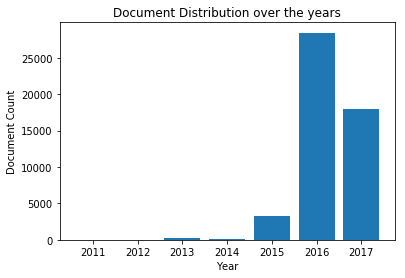

In [6]:
import matplotlib.pyplot as plt
# create a figure and axis 
fig, ax = plt.subplots() 
# count the occurrence of each class
dfcount_per_year = dfyear.size().reset_index(name='count_per_year')
data =dfcount_per_year['count_per_year'] 
# get x and y data 
points = dfcount_per_year['year'] 
frequency = data.values 
# create bar chart 
ax.bar(points, frequency) 
# set title and labels 
ax.set_title('Document Distribution over the years') 
ax.set_xlabel('Year') 
ax.set_ylabel('Document Count')
dfcount_per_year

### Creating data vectors

In [57]:
from sklearn.feature_extraction.text import CountVectorizer

data = []
 
for article in df_content.values:
    document = ' '.join(article)
    data.append(document)
 
NO_DOCUMENTS = len(data)
print(NO_DOCUMENTS)

vectorizer = CountVectorizer(min_df=5, max_df=0.9, 
                             stop_words='english', lowercase=True, 
                             token_pattern='[a-zA-Z][a-zA-Z]{2,}')
data_vectorized = vectorizer.fit_transform(data)

50000


###Plotting words and documents in 2D with SVD

First figure displays the documents in 2D whereas second figure displays the words (will later be translated to topics) in 2D.

The more closer the documents are in this space, the similarity they will have. We can cross check by manually checking the documents in the data to validate.

In [49]:
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, LabelSet
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
output_notebook()

svd = TruncatedSVD(n_components=2)
documents_2d = svd.fit_transform(data_vectorized)
 
df = pd.DataFrame(columns=['x', 'y', 'document'])
df['x'], df['y'], df['document'] = documents_2d[:,0], documents_2d[:,1], range(len(data))
 
source = ColumnDataSource(ColumnDataSource.from_df(df))
labels = LabelSet(x="x", y="y", text="document", y_offset=8,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
 
plot = figure(plot_width=600, plot_height=600)
plot.circle("x", "y", size=12, source=source, line_color="black", fill_alpha=0.8)
plot.add_layout(labels)
show(plot, notebook_handle=True)

In [50]:
import pandas as pd
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, LabelSet
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
output_notebook()

svd = TruncatedSVD(n_components=2)
words_2d = svd.fit_transform(data_vectorized.T)
 
df = pd.DataFrame(columns=['x', 'y', 'word'])
df['x'], df['y'], df['word'] = words_2d[:,0], words_2d[:,1], vectorizer.get_feature_names()
 
source = ColumnDataSource(ColumnDataSource.from_df(df))
labels = LabelSet(x="x", y="y", text="word", y_offset=8,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
 
plot = figure(plot_width=600, plot_height=600)
plot.circle("x", "y", size=12, source=source, line_color="black", fill_alpha=0.8)
plot.add_layout(labels)
show(plot, notebook_handle=True)

##Preprocessing the news articles

Steps followed:

1. We split an article into sentences and further use gensim preprocessor to tokenize the words. This step removes the punctuation as well.
2. We remove the stopwords from tokens that are lowercased  using the nltk stopwords list. Based on the observations in the dataset, it seems the publications' name is repeated a lot. This could add noise to the corpus, so we add the names of the publications to the stopwords as well. We also remove the words like "See photos from", "here all about" as these appear in photo articles. After removing these words, we see lesser noise.

3.  We lemmatize the bigrams/trigrams  and we keep the words that are longer than 2 letters. We do not convert the tokens into lowercase for this step as lemmatizer would give out different output based on case of the letter as POS tagging needs the casing to figure out the difference between a regular verb or a word used as noun. Excluding all the other POS tags except noun, adjective, verb and adverb gave better results.
4. Next, we convert the filtered tokens into bigrams (i.e. pairs to two). We use a minimum threshold i.e. the minimum number of times a word should appear in the entire corpus.
5. Optionally, using the same process as above for bigrams, we convert them into trigrams.


In [3]:
### Text Cleaning ### 

## Lemmatizing 
import re
import nltk
import gensim
import pickle
from gensim import models, corpora
from gensim.models import CoherenceModel
from smart_open import smart_open
nltk.download('stopwords')
nltk.download('punkt') 
import spacy
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(["see","photos","from","all","about", "cnn", "breitbart","publication","atlantic","here","look"])
import logging # This allows for seeing if the model converges. A log file is created.
logging.basicConfig(filename='lda_model.log', format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

nlp_en = spacy.load("en_core_web_sm")

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in gensim.utils.simple_preprocess(str(doc)) if word.lower() not in stop_words] for doc in texts]
  
# Build the bigram models
def bigrams(words, bi_min=15):
    bigram = gensim.models.Phrases(words, min_count = bi_min)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    return bigram_mod
  
  # Build the bigram models
def trigrams(words, bi_min=15, tri_min=10):
    bigram = gensim.models.Phrases(words, min_count = bi_min)
    trigram = gensim.models.Phrases(bigram[data_words], threshold=tri_min)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    return trigram_mod
  
def make_bigrams(texts):
    bigram_mod = bigrams(texts)
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    bigram_mod = bigrams(texts)
    trigram_mod = trigrams(texts)
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

# create a filtered lemmas to exclude determiners (DET), adpositions(aka prepositions) (ADP), 
# punctuation (PUNCT), conjuctions (CONJ,CCONJ),subordinating conjunction(SCONJ), numerals (NUM), symbols (SYM), spaces (SPACE),
# auxillary (AUX), particle (PART), pronoun (PRON), helping verb (HVS), interjection(INTJ)
# and non-alpha tokens. We will also filter stopwords. 
# Full list can be found at https://spacy.io/api/annotation
# allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']
# filter_tags = ["DET","ADP","PUNCT","CONJ","CCONJ","SCONJ","NUM","SYM","SPACE","AUX","PART","PRON","HVS","INTJ"]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        lemmas = [(token.text, token.lemma_) for token in doc if token.pos_ in allowed_postags 
                  and token.text.isalpha() and len( str(token.lemma_)) > 2]
        texts_out.append([lemma[1] for lemma in lemmas])
    return texts_out

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(df_content.values.tolist()))
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en', disable=['parser', 'ner'])
# Do lemmatization keeping only noun, adj, vb, adv
lemmatized_data = lemmatization(data_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
# Form Bigrams
#ngrams_data = make_bigrams(lemmatized_data)
# Form Trigrams
ngrams_data = make_trigrams(lemmatized_data)
preprocessed_data = []
for sent in ngrams_data:
  preprocessed_data.append([token for token in sent if len(str(token))>3])

print(preprocessed_data[1])

['life', 'michelle_obama', 'wife', 'president_barack_obama', 'personal_birth_date', 'january', 'birth_place_chicago', 'illinois_birth_name', 'michelle', 'lavaughn', 'robinson', 'father', 'fraser', 'robinson', 'water', 'filtration', 'worker', 'mother', 'marian', 'shield', 'robinson', 'marriage', 'barack_obama', 'october', 'child', 'sasha', 'malia', 'education', 'princeton_university', 'harvard_university', 'religion', 'christian', 'fact', 'graduate', 'magna', 'laude', 'sociology', 'degree', 'princeton', 'meet', 'barack_obama', 'assign', 'mentor', 'sidley', 'austin', 'chicago', 'law_firm', 'father', 'suffer', 'eventually', 'multiple', 'sclerosis', 'timeline', 'associate', 'attorney', 'sidley', 'austin', 'chicago', 'assistant', 'chicago', 'mayor', 'richard', 'daley', 'assistant', 'commissioner', 'planning', 'development', 'found', 'executive_director', 'public', 'ally', 'chicago', 'associate', 'dean', 'student', 'service', 'university', 'chicago', 'director', 'university', 'community', 's

##Finding the optimal number of topics for LDA using GridSearchCV

In [11]:
!pip install -U scikit-learn 
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
# Define Search Param
search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(n_components=10, doc_topic_prior=None, topic_word_prior=None,
                                            learning_method=None, learning_decay=0.7, learning_offset=10.0,
                                            max_iter=10, batch_size=128, evaluate_every=-1, total_samples=1000000.0,
                                            perp_tol=0.1, mean_change_tol=0.001, max_doc_update_iter=100,
                                           n_jobs=None, verbose=0, random_state=None),
       iid=True, n_jobs=-1,
       param_grid={'n_topics': [10, 15, 20, 25, 30], 'learning_decay': [0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.21.3)
Best Model's Params:  {'learning_decay': 0.7, 'n_components': 10}
Best Log Likelihood Score:  -283512.13628652855
Model Perplexity:  1651.4451349005203


#Training Gensim LDA for topic modelling

To build a LDA model, we follow the steps as below:

1. Based on the optimal number of components given as an output by GirdSearchCV, we choose the number of topics for our LDA model. e.g. GridSearchSV shows *Best Model's Params:  {'learning_decay': 0.9, 'n_components': 10}* , so we choose 10 topics.

2. Create a dictionary object from the preprocessed data.
3. Filter the extremes in the dataset i.e. keep only the words the appear in atleast 10 documents and are also not in more than 25% of the total documents. Also, we truncate the number of words based on keep_n value.
4. We create the corpus from this dictionary
5. We also tried using TFIDF ( term frequency inverse document frequency). This removes the most common and the most rare words based on their frequency in the dataset. But we saw the coherence of our LDA model kept dropping on using TFIDF and dropped its use. Gensim LDA anyway uses TFIDF internally, possibly which is why it is kind of redundant to use it again explicitly.

Finally we use multicore version of LDA from Gensim to build the model for topic modelling. We used 50 passes, number of topics found by GridSearch, evaluated coherence after every pass.

In [27]:
NUM_TOPICS = model.best_params_['n_components']
#choosing topics based on coherence score of the last LDA model
#NUM_TOPICS=14
 
# Create Dictionary
train_id2word = corpora.Dictionary(preprocessed_data)
train_id2word.filter_extremes(no_below=10, no_above=0.25,keep_n=100000)
train_id2word.compactify()

# Term Document Frequency
train_corpus = [train_id2word.doc2bow(text) for text in preprocessed_data]
#tfidf_model = gensim.models.TfidfModel(train_corpus)
#train_corpus = tfidf_model[train_corpus]
# Save the corpus with pickle
pickle.dump(train_corpus, smart_open('corpus.pkl', 'wb'))
train_id2word.save('dictionary.gensim') 
 
# Human readable format of corpus (term-frequency)
[[(train_id2word[id], freq) for id, freq in cp] for cp in train_corpus[:1]]


[[('ability', 1),
  ('activity', 1),
  ('agree', 2),
  ('agreement', 2),
  ('allegation', 1),
  ('approve', 2),
  ('assistant', 1),
  ('attorney_general', 1),
  ('behalf', 1),
  ('civil', 3),
  ('claim', 2),
  ('company', 2),
  ('corp', 1),
  ('cost', 1),
  ('criminal', 2),
  ('decision', 1),
  ('dollar', 1),
  ('drug', 1),
  ('effective', 1),
  ('false', 1),
  ('fine', 1),
  ('firm', 1),
  ('good', 1),
  ('government', 1),
  ('health_care', 1),
  ('illegal', 2),
  ('interim', 1),
  ('justice', 1),
  ('justice_department', 2),
  ('keep', 1),
  ('letter', 1),
  ('market', 1),
  ('medical', 2),
  ('medicine', 1),
  ('nearly', 2),
  ('official', 2),
  ('participate', 1),
  ('patient', 1),
  ('place', 1),
  ('plead_guilty', 1),
  ('promote', 1),
  ('purpose', 1),
  ('record', 2),
  ('relate', 1),
  ('remain', 1),
  ('resolve', 2),
  ('rule', 1),
  ('safe', 1),
  ('safety', 1),
  ('send', 1),
  ('settlement', 5),
  ('statement', 1),
  ('stem', 1),
  ('tony', 1),
  ('total', 1),
  ('warning'

In [0]:
# Build the LDA model
lda_train = gensim.models.ldamulticore.LdaMulticore(
                           corpus=train_corpus,
                           num_topics=NUM_TOPICS,
                           id2word=train_id2word,
                           chunksize=100,
                           workers=4, # Num. Processing Cores - 1
                           passes=50,
                           eval_every = 1,
                           per_word_topics=True)

lda_train.save('model_lda_train.gensim')

##View the topics in LDA model 
The above LDA model is built with *n* different topics where each topic is a combination of keywords and each keyword contributes a certain weightage to the topic.

You can see the keywords for each topic and the weightage(importance) of each keyword using lda_model.print_topics() as shown below

In [29]:
from pprint import pprint
# Print the Keyword in the topics
pprint(lda_train.print_topics())
df_keywords_and_topics = pd.DataFrame(lda_train.print_topics())
doc_lda = lda_train[train_corpus]
df_keywords_and_topics

[(0,
  '0.015*"party" + 0.013*"iran" + 0.012*"prime_minister" + 0.012*"meet" + '
  '0.011*"visit" + 0.011*"kill" + 0.010*"high_school" + 0.010*"government" + '
  '0.010*"prison" + 0.010*"leader"'),
 (1,
  '0.020*"attack" + 0.011*"government" + 0.009*"official" + 0.009*"military" + '
  '0.007*"flight" + 0.007*"mission" + 0.007*"bombing" + 0.006*"crew" + '
  '0.006*"north_korea" + 0.006*"document"'),
 (2,
  '0.021*"award" + 0.016*"good" + 0.014*"film" + 0.011*"actor" + 0.010*"star" '
  '+ 0.010*"television" + 0.009*"movie" + 0.008*"live" + 0.006*"album" + '
  '0.006*"record"'),
 (3,
  '0.019*"kill" + 0.016*"race" + 0.011*"food" + 0.010*"market" + 0.010*"line" '
  '+ 0.009*"area" + 0.008*"fire" + 0.008*"mile" + 0.008*"hour" + '
  '0.007*"station"'),
 (4,
  '0.017*"senate" + 0.015*"nato" + 0.015*"paul" + 0.013*"commission" + '
  '0.011*"governor" + 0.010*"chairman" + 0.009*"georgia" + 0.008*"hospital" + '
  '0.008*"surgery" + 0.008*"vote"'),
 (5,
  '0.034*"game" + 0.033*"player" + 0.028*"t

0                                                  1
0  0  0.015*"party" + 0.013*"iran" + 0.012*"prime_mi...
1  1  0.020*"attack" + 0.011*"government" + 0.009*"o...
2  2  0.021*"award" + 0.016*"good" + 0.014*"film" + ...
3  3  0.019*"kill" + 0.016*"race" + 0.011*"food" + 0...
4  4  0.017*"senate" + 0.015*"nato" + 0.015*"paul" +...
5  5  0.034*"game" + 0.033*"player" + 0.028*"team" +...
6  6  0.016*"study" + 0.013*"parent" + 0.011*"infect...
7  7  0.015*"file" + 0.013*"murder" + 0.012*"victim"...
8  8  0.011*"would" + 0.010*"tell" + 0.009*"want" + ...
9  9  0.034*"isis" + 0.026*"iraq" + 0.025*"iraqi" + ...

##Compute Model Perplexity and Coherence Score
Model perplexity and topic coherence provide a convenient measure to judge how good is a given topic model. Perplexity value should be as lower as it can be for a good model where cohernce of more than 0.50 or close to the value would be a sign of good model.

In [16]:
# Compute Perplexity
print('\nPerplexity: ', lda_train.log_perplexity(train_corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_train, texts=preprocessed_data, dictionary=train_id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.888469509081871

Coherence Score:  0.47576940187673655


## Alternate way to find the optimal number of topics for LDA
This approach  builds many LDA models with different values of number of topics (k) and pick the one that gives the highest coherence value.

Choosing a ‘k’ that marks the end of a rapid growth of topic coherence usually offers meaningful and interpretable topics. Picking an even higher value can sometimes provide more granular sub-topics.

In [0]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaModel(corpus=corpus, num_topics=NUM_TOPICS, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [0]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=train_id2word, corpus=train_corpus, texts=preprocessed_data, start=2, limit=60, step=6)

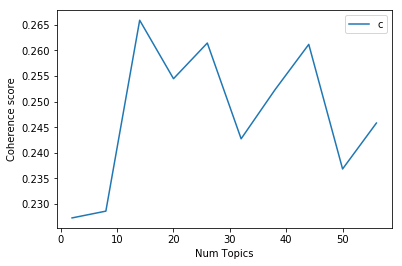

In [22]:
# Show graph
import matplotlib.pyplot as plt
limit=60; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [23]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2273
Num Topics = 8  has Coherence Value of 0.2286
Num Topics = 14  has Coherence Value of 0.2659
Num Topics = 20  has Coherence Value of 0.2545
Num Topics = 26  has Coherence Value of 0.2614
Num Topics = 32  has Coherence Value of 0.2427
Num Topics = 38  has Coherence Value of 0.2523
Num Topics = 44  has Coherence Value of 0.2611
Num Topics = 50  has Coherence Value of 0.2369
Num Topics = 56  has Coherence Value of 0.2458


#2. Key-phrases extraction and ranking

Once we run LDA over the dataset, as a output from the model, we can get the topics it identified. Along with that, the algorithm gives out the keywords for each topic with their weightage(ranking). The sum of weightage of all the keywords in a topic would always be equal to 1. 

We  display the keywords in 2 different ways:

1. Print the topics from LDA which gives out the tuples like this - (topic, rank*keyword). The keywords are already ranked by the LDA.

2. Using the pyLDAvis library.

##Visualize in the dataframe the topics and their respective keywords



In [30]:
  print(df_keywords_and_topics.values)
  #values obtained in the last run
  '''
  (1,
  '0.016*"isis" + 0.015*"kill" + 0.014*"iraq" + 0.014*"force" + '
  '0.013*"military" + 0.011*"iraqi" + 0.011*"government" + 0.011*"attack" + '
  '0.010*"syria" + 0.009*"group"'),
 (2,
  '0.014*"file" + 0.012*"court" + 0.011*"case" + 0.010*"judge" + 0.009*"study" '
  '+ 0.009*"appeal" + 0.008*"count" + 0.008*"lawsuit" + 0.008*"trial" + '
  '0.008*"cell"'),
 (3,
  '0.015*"attack" + 0.011*"senate" + 0.011*"north_korea" + 0.009*"commission" '
  '+ 0.008*"official" + 0.008*"committee" + 0.008*"government" + '
  '0.007*"governor" + 0.007*"trial" + 0.007*"iran"'),
 (4,
  '0.015*"right" + 0.013*"supreme_court" + 0.012*"amendment" + 0.011*"texas" + '
  '0.011*"vote" + 0.010*"party" + 0.009*"capture" + 0.009*"constitution" + '
  '0.008*"justice" + 0.008*"damage"'),
 (5,
  '0.033*"kill" + 0.029*"murder" + 0.020*"fire" + 0.018*"prison" + '
  '0.017*"execution" + 0.016*"high_school" + 0.015*"death_penalty" + '
  '0.015*"victim" + 0.013*"school" + 0.012*"student"'),
 (6,
  '0.023*"veteran" + 0.017*"infection" + 0.016*"food" + 0.014*"market" + '
  '0.013*"paul" + 0.012*"test" + 0.009*"hospital" + 0.008*"cause" + '
  '0.008*"case" + 0.008*"system"'),
 (7,
  '0.020*"award" + 0.014*"good" + 0.014*"film" + 0.010*"star" + '
  '0.009*"television" + 0.009*"actor" + 0.008*"movie" + 0.007*"live" + '
  '0.006*"college" + 0.006*"play"'),
 (8,
  '0.012*"would" + 0.011*"tell" + 0.011*"want" + 0.009*"parent" + '
  '0.008*"could" + 0.008*"come" + 0.008*"white" + 0.007*"think" + 0.007*"feel" '
  '+ 0.007*"line"'),
 (9,
  '0.013*"house" + 0.011*"flight" + 0.011*"city" + 0.011*"tower" + '
  '0.010*"open" + 0.010*"foot" + 0.010*"event" + 0.009*"building" + '
  '0.009*"police" + 0.009*"crew"')]
  '''

[[0
  '0.015*"party" + 0.013*"iran" + 0.012*"prime_minister" + 0.012*"meet" + 0.011*"visit" + 0.011*"kill" + 0.010*"high_school" + 0.010*"government" + 0.010*"prison" + 0.010*"leader"']
 [1
  '0.020*"attack" + 0.011*"government" + 0.009*"official" + 0.009*"military" + 0.007*"flight" + 0.007*"mission" + 0.007*"bombing" + 0.006*"crew" + 0.006*"north_korea" + 0.006*"document"']
 [2
  '0.021*"award" + 0.016*"good" + 0.014*"film" + 0.011*"actor" + 0.010*"star" + 0.010*"television" + 0.009*"movie" + 0.008*"live" + 0.006*"album" + 0.006*"record"']
 [3
  '0.019*"kill" + 0.016*"race" + 0.011*"food" + 0.010*"market" + 0.010*"line" + 0.009*"area" + 0.008*"fire" + 0.008*"mile" + 0.008*"hour" + 0.007*"station"']
 [4
  '0.017*"senate" + 0.015*"nato" + 0.015*"paul" + 0.013*"commission" + 0.011*"governor" + 0.010*"chairman" + 0.009*"georgia" + 0.008*"hospital" + 0.008*"surgery" + 0.008*"vote"']
 [5
  '0.034*"game" + 0.033*"player" + 0.028*"team" + 0.028*"veteran" + 0.023*"season" + 0.021*"play" + 0.01

'\n(1,\n\'0.016*"isis" + 0.015*"kill" + 0.014*"iraq" + 0.014*"force" + \'\n\'0.013*"military" + 0.011*"iraqi" + 0.011*"government" + 0.011*"attack" + \'\n\'0.010*"syria" + 0.009*"group"\'),\n (2,\n\'0.014*"file" + 0.012*"court" + 0.011*"case" + 0.010*"judge" + 0.009*"study" \'\n\'+ 0.009*"appeal" + 0.008*"count" + 0.008*"lawsuit" + 0.008*"trial" + \'\n\'0.008*"cell"\'),\n (3,\n\'0.015*"attack" + 0.011*"senate" + 0.011*"north_korea" + 0.009*"commission" \'\n\'+ 0.008*"official" + 0.008*"committee" + 0.008*"government" + \'\n\'0.007*"governor" + 0.007*"trial" + 0.007*"iran"\'),\n (4,\n\'0.015*"right" + 0.013*"supreme_court" + 0.012*"amendment" + 0.011*"texas" + \'\n\'0.011*"vote" + 0.010*"party" + 0.009*"capture" + 0.009*"constitution" + \'\n\'0.008*"justice" + 0.008*"damage"\'),\n (5,\n\'0.033*"kill" + 0.029*"murder" + 0.020*"fire" + 0.018*"prison" + \'\n\'0.017*"execution" + 0.016*"high_school" + 0.015*"death_penalty" + \'\n\'0.015*"victim" + 0.013*"school" + 0.012*"student"\'),\n (6,\

 ## Visualize the topics-keywords using pyLDAvis library
 
Now that the LDA model is built, the next step is to examine the produced topics and the associated keywords. We use pyLDAvis to visualize the topics.

Each bubble on the left-hand side plot represents a topic. The larger the bubble, the more prevalent is that topic.

A good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant.

A model with too many topics, will typically have many overlaps, small sized bubbles clustered in one region of the chart.

As we see below, we have a fairly good model where only 2 pairs of topics are overlapping and the rest are scattered all over the chart and have a good distance between them all to say they are well defined topics.

In [11]:
import gensim
!pip install pyLDAvis
# We can now output a visualization of the possible topics

dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
corpus = pickle.load(smart_open('corpus.pkl','rb'))
lda = gensim.models.LdaModel.load('model_lda_train.gensim')

# Library to visualize the LDA
import pyLDAvis.gensim

# set up the display features 
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

     |████████████████████████████████| 1.6MB 2.9MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97712 sha256=b805aa4e7dc8b4365d94b631c5bc79f0f29999048178a8d3e84ef4d22dce60df
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyLDAvis


#Sub-topic idenitification over a period of time using DTM

 Topics distribution in time also a way to identify new and upcoming sub-topics within each topic. 
 
 Lets prepare the data for LDA in a way that the articles written in the same year and same month are clubbed together. This makes the dynamic time models efficient. 
 
 We use LDASEQ i.e. a dynamic time model used to model the data using time slices as a reference. We have to provide the time slices array based on which the algorithm will divide the dataset and run LDA over sliced datasets. 
 
 From the output of this model, we can the topics modelled based on time series and can compare how the topics evolved over time.

## Preprocessing the data for  sub-topic identification

Prepare the data by clubbing the data from same and same month together.

In [31]:
#prepare the data for sub-topics identification by grouping the data based on year and month
df_year = df_all.groupby('year')
df_count_per_year = df_year.size().reset_index(name='count_per_year')
df_year_month = df_all.groupby(['year', 'month'])

#lets get the counts per year and per month
df_count_per_month = df_year_month.size().reset_index(name='count_per_month')

print(df_count_per_year)
print(df_count_per_month)

     year  count_per_year
0  2011.0               1
1  2012.0              26
2  2013.0             212
3  2014.0              76
4  2015.0            3326
5  2016.0           28451
6  2017.0           17908
      year  month  count_per_month
0   2011.0   11.0                1
1   2012.0    4.0                1
2   2012.0    5.0                2
3   2012.0    6.0                1
4   2012.0    7.0                2
5   2012.0    8.0                1
6   2012.0    9.0                2
7   2012.0   10.0                2
8   2012.0   11.0                1
9   2012.0   12.0               14
10  2013.0    1.0               15
11  2013.0    2.0                9
12  2013.0    3.0               12
13  2013.0    4.0               12
14  2013.0    5.0               25
15  2013.0    6.0               23
16  2013.0    7.0               29
17  2013.0    8.0               28
18  2013.0    9.0               33
19  2013.0   10.0               17
20  2013.0   11.0                7
21  2013.0   12.0     

As we see the data is quite imbalanced in terms of time series, we will try to model the topics from fairly balanced years.

In [0]:
# setting up our imports

from gensim.models import ldaseqmodel
from gensim.corpora import Dictionary, bleicorpus
import numpy
from gensim.matutils import hellinger

In [58]:
time_slice = df_count_per_year['count_per_year'].values
time_slice

array([    1,    26,   212,    76,  3326, 28451, 17908])

In [0]:
ldaseq = ldaseqmodel.LdaSeqModel(corpus=train_corpus, id2word=train_id2word, time_slice=time_slice, num_topics=NUM_TOPICS)
ldaseq.save('ldaseq.gensim')

##Visualizing Topics and identifying sub-topics
The input parameter to print_topics is a time-slice option. By passing 0 we are seeing the topics in the 1st time-slice.

In [45]:
ldaseq.print_topics(time=0)

[[('award', 0.03897962231606732),
  ('good', 0.02998563678182684),
  ('market', 0.018037282828589234),
  ('film', 0.01751734886611529),
  ('actor', 0.01709599016250423),
  ('television', 0.013714823840975467),
  ('record', 0.01183631670563837),
  ('winner', 0.011640226866992863),
  ('live', 0.01153417529760897),
  ('win_grammy', 0.011530849348472365),
  ('album', 0.010936325588223774),
  ('present', 0.009646536093127198),
  ('outstanding', 0.009166326522833132),
  ('song', 0.008800228408685638),
  ('host', 0.00846613984251343),
  ('motion_picture', 0.008098951875357314),
  ('academy', 0.007865591696478248),
  ('nominate', 0.0076917286712214795),
  ('actress', 0.00762995793184648),
  ('young', 0.007114852206138472)],
 [('iraq', 0.01253106197766377),
  ('government', 0.0119442517118278),
  ('force', 0.011531795214978347),
  ('military', 0.009171108090778987),
  ('party', 0.008825534744734435),
  ('prime_minister', 0.008774895494565586),
  ('syria', 0.008504238245152132),
  ('leader', 0.0

We can see 10 different sub topics and will  see which umbrella topic they fit under:

1.  Sports
2.  Music awards  - **Entertainment**
3.  International relations - **Trade**
4. Lifestyle/common
5. Criminal Proceedings - **Crime**
6. Movies - **Entertainment**
7. ISIS/Syria - **Terrorism**
8. Politics with Russia - **Politics**
9. Not so clear
10. Plane crash - **Accidents**



##Looking for Topic Evolution over a period of time
To fix a topic and see it evolve, use print_topic_times. The input parameter is the topic_id In this case, we are looking at the evolution of the Sports topic based on the currently trained model.

In [20]:
ldaseq.print_topic_times(topic=0)

[[('award', 0.03897962231606732),
  ('good', 0.02998563678182684),
  ('market', 0.018037282828589234),
  ('film', 0.01751734886611529),
  ('actor', 0.01709599016250423),
  ('television', 0.013714823840975467),
  ('record', 0.01183631670563837),
  ('winner', 0.011640226866992863),
  ('live', 0.01153417529760897),
  ('win_grammy', 0.011530849348472365),
  ('album', 0.010936325588223774),
  ('present', 0.009646536093127198),
  ('outstanding', 0.009166326522833132),
  ('song', 0.008800228408685638),
  ('host', 0.00846613984251343),
  ('motion_picture', 0.008098951875357314),
  ('academy', 0.007865591696478248),
  ('nominate', 0.0076917286712214795),
  ('actress', 0.00762995793184648),
  ('young', 0.007114852206138472)],
 [('award', 0.03938994885524781),
  ('good', 0.030088612417545745),
  ('film', 0.017557360178586386),
  ('actor', 0.017159243751628736),
  ('market', 0.01697551154362877),
  ('television', 0.013821777522967905),
  ('record', 0.011876080847535797),
  ('winner', 0.01172354768

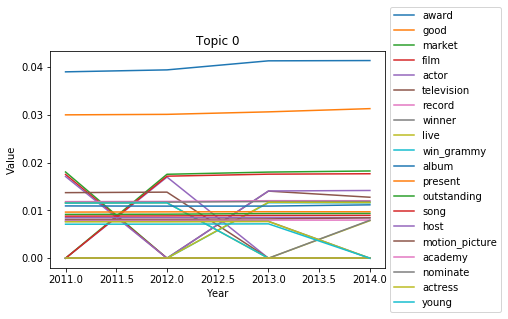

In [41]:
import matplotlib.pyplot as plt 

time_series_topic_0 = ldaseq.print_topic_times(topic=0)

no_of_words = len(time_series_topic_0[0])
words_list = [x[0] for x in time_series_topic_0[0]]

x_axis_values = df_count_per_year['year'].values[:4]
x_axis_values = [int(x) for x in x_axis_values]

for i in range(0,no_of_words):
  x1 = x_axis_values
  y1 = []
  for cp in time_series_topic_0:
    frequencies = []
    for (word, freq) in cp:
      if word==words_list[i]:
        frequencies.append(freq)
      else:
        frequencies.append(0)
    y1.append(frequencies)
  word = words_list[i]
  plt.plot(x1, y1) 
  
# naming the x axis 
plt.xlabel('Year') 
# naming the y axis 
plt.ylabel('Value') 
# giving a title to my graph 
plt.title('Topic 0') 
  
# show a legend on the plot 
plt.legend(words_list,loc='center left', bbox_to_anchor=(1, 0.5)) 
  
# function to show the plot 
plt.show()

##Document - Topic Proportions
The function doc_topics checks the topic proportions on documents already trained on. It accepts the document number in the corpus as an input.

Let's pick up document number 300 arbitrarily and have a look.

With the current model- we see the document is close to topic number - 3 i.e. almost 95% similarity

Current model output of topics, based on the keywords, we can definitely say that this document falls under topic -3.

**Topic 3 -**

('play', 0.016239484861815957),
  ('game', 0.016126854389842283),
  ('team', 0.014175907866362154),
  ('player', 0.01187289494307718),
  ('king', 0.011325075359850596),
  ('star', 0.010807947895815009),
  ('movie', 0.0089884470302681),
  ('new_york', 0.008528828496155022),
  ('company', 0.007712306315220297),
  ('film', 0.007036343453372028),
  ('club', 0.006261003563816248),
  ('final', 0.00607341489168392),
  ('chicago', 0.005968217157428708),
  ('open', 0.005882836574543067),
  ('richard', 0.005686774483097212),
  ('college', 0.005585186517875526),
  ('book', 0.005488832172759327),
  ('appear', 0.005442732206563589),
  ('surgery', 0.005420848388441491),
  ('launch', 0.0053100351622540655)

In [44]:
# to check Document - Topic proportions, use `doc-topics`
words = [train_id2word[word_id] for word_id, count in train_corpus[300]]
print (words)

doc = ldaseq.doc_topics(300) # check the 300th document in the corpuses topic distribution
print (doc)

['celebrity', 'twitter']
[0.0047619  0.0047619  0.95714286 0.0047619  0.0047619  0.0047619
 0.0047619  0.0047619  0.0047619  0.0047619 ]


##Choosing the best Dynamic Topic Model

Chain Variance
One of the key aspects of topic evolution is how fast/slow these topics evolve. And this is where the factor of variance comes in. By setting the chain_variance input to the DTM model higher, we can tweak our topic evolution. The default value is 0.005.

Let us see a small example illustrating the same. Let's first see the evolution of values for the first time-slice

In [51]:
ldaseq.print_topic_times(1)

[[('senate', 0.017972954018649286),
  ('race', 0.01745323867789153),
  ('market', 0.01298492168190599),
  ('commission', 0.012114502057238869),
  ('nato', 0.011715270246335644),
  ('committee', 0.010541485296286277),
  ('georgia', 0.010022505539412516),
  ('international', 0.009062949992574065),
  ('governor', 0.008582071460767563),
  ('chairman', 0.008416297042534684),
  ('federal', 0.007336608387571031),
  ('appoint', 0.006647239193355947),
  ('new_york', 0.006574995929080581),
  ('unite_state', 0.006543818229955533),
  ('senator', 0.00644422833229401),
  ('paul', 0.006012082204184365),
  ('school', 0.005974026358115803),
  ('celebrate', 0.005762772941457893),
  ('economic', 0.0053799259119861114),
  ('france', 0.005209954816816877)],
 [('senate', 0.018128562497768345),
  ('race', 0.017691854276169008),
  ('market', 0.012632501159695865),
  ('commission', 0.012210222171458873),
  ('nato', 0.011773754766687612),
  ('committee', 0.01059382768884136),
  ('georgia', 0.009927396031661023)

In [34]:
ldaseq_chain = ldaseqmodel.LdaSeqModel(corpus=train_corpus, id2word=train_id2word, time_slice=time_slice, num_topics=NUM_TOPICS, chain_variance=0.05)
ldaseq_chain.save('ldaseq_chain.gensim')
ldaseq_chain.print_topic_times(2)

[[('attack', 0.02909790862622957),
  ('kill', 0.027194507080293077),
  ('north_korea', 0.02351166360513353),
  ('capture', 0.01919697886892793),
  ('military', 0.017825219025904893),
  ('force', 0.01608782336727672),
  ('bomb', 0.015138088251848675),
  ('group', 0.012464364992919223),
  ('iraqi', 0.01107648822984069),
  ('soldier', 0.010844482601152271),
  ('troop', 0.010400873232767296),
  ('official', 0.01021519551415219),
  ('government', 0.009804372092960761),
  ('claim', 0.009753455907009666),
  ('militant', 0.00933543211668009),
  ('operation', 0.00926369292503195),
  ('civilian', 0.009161266106458156),
  ('afghanistan', 0.007970651434926899),
  ('transfer', 0.0077785431247165285),
  ('video', 0.0072560948611247724)],
 [('attack', 0.02916035466811031),
  ('kill', 0.027254495901719328),
  ('north_korea', 0.02355011678220857),
  ('capture', 0.019216682308214633),
  ('military', 0.01785387903549719),
  ('force', 0.01611058855400479),
  ('bomb', 0.015154462177489843),
  ('group', 0.0

##Visualising Dynamic Topic Models
Let us use pyLDAvis to visualise LDASEQ output. With the new DTMvis methods it is now very straightforward to visualise DTM for a particular time-slice.

The more sparsely spread the topics are in the different quadrants, the better our model is.

In [55]:
from gensim.models.wrappers.dtmmodel import DtmModel
from gensim.corpora import Dictionary, bleicorpus
import pyLDAvis

#load the saved model,dictionary and corpus
lda_seq = ldaseqmodel.LdaSeqModel.load('ldaseq.gensim')
dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
corpus = pickle.load(smart_open('corpus.pkl','rb'))
doc_topic, topic_term, doc_lengths, term_frequency, vocab = lda_seq.dtm_vis(time=0, corpus=corpus)
vis_dtm = pyLDAvis.prepare(topic_term_dists=topic_term, doc_topic_dists=doc_topic, doc_lengths=doc_lengths, vocab=vocab, term_frequency=term_frequency)
pyLDAvis.display(vis_dtm)

##Topic Coherence for LDASEQ (DTM)

Based on the below coherence score, we see by changing the chain variance value, we got a better DTM LDASEQ model. The higher the coherence value, the better the model.

In [41]:
from gensim.models.coherencemodel import CoherenceModel
import pickle

# we just have to specify the time-slice we want to find coherence for.
lda_seq = ldaseqmodel.LdaSeqModel.load('ldaseq.gensim')
lda_seq_chain = ldaseqmodel.LdaSeqModel.load('ldaseq_chain.gensim')
dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
corpus = pickle.load(smart_open('corpus.pkl','rb'))
topics_dtm = lda_seq.dtm_coherence(time=2)

# running u_mass coherence on our model
cm_DTM = CoherenceModel(topics=topics_dtm, corpus=corpus, dictionary=dictionary, coherence='u_mass')

print ("U_mass topic coherence")
print ("DTM Python coherence is", cm_DTM.get_coherence())

topics_dtm_chain = lda_seq_chain.dtm_coherence(time=2)

# running u_mass coherence on our model
cm_DTM = CoherenceModel(topics=topics_dtm_chain, corpus=corpus, dictionary=dictionary, coherence='u_mass')

print ("U_mass topic coherence")
print ("DTM Python coherence for optimal DTM is", cm_DTM.get_coherence())

U_mass topic coherence
DTM Python coherence is -2.1528458069960967
U_mass topic coherence
DTM Python coherence for optimal DTM is -1.919406803687221


#Sentiment Analysis of Topics with AFINN Lexicon and TextBlob

We use the vocabulary-based unsupervised sentiment analysis techniques. Both AFINN lexicon and TextBlob are widely known for sentiment analysis as these contain a large number of words with polarity values.

Input values are coming from the output of LDA algorithm. We can also use LDASEQ output and see how the sentiment changes over time.

For now, we are focusing on the overall sentiment of topics, therefore will use LDA outout instead of DTM algorithm.

##Preprocess the topics and Keywords for sentiment analysis

In [55]:
#preprocess the keywords out our topics. The format of the LDA output is like below:
'''
(1,
  '0.016*"isis" + 0.015*"kill" + 0.014*"iraq" + 0.014*"force" + '
  '0.013*"military" + 0.011*"iraqi" + 0.011*"government" + 0.011*"attack" + '
  '0.010*"syria" + 0.009*"group"')
 
'''

topics_list=[]
for (topic, keyword) in df_keywords_and_topics.values:
    w_k = keyword.split('+')
    w_k = [word.strip() for word in w_k]
    only_keywords=[]
    for word in w_k:
        only_keywords.append(word[6:].replace('"',' '))
    topics_list.append(''.join(only_keywords))

df_keywords_and_topics

0                                                  1
0  0  0.015*"party" + 0.013*"iran" + 0.012*"prime_mi...
1  1  0.020*"attack" + 0.011*"government" + 0.009*"o...
2  2  0.021*"award" + 0.016*"good" + 0.014*"film" + ...
3  3  0.019*"kill" + 0.016*"race" + 0.011*"food" + 0...
4  4  0.017*"senate" + 0.015*"nato" + 0.015*"paul" +...
5  5  0.034*"game" + 0.033*"player" + 0.028*"team" +...
6  6  0.016*"study" + 0.013*"parent" + 0.011*"infect...
7  7  0.015*"file" + 0.013*"murder" + 0.012*"victim"...
8  8  0.011*"would" + 0.010*"tell" + 0.009*"want" + ...
9  9  0.034*"isis" + 0.026*"iraq" + 0.025*"iraqi" + ...

##Sentiment analysis using AFINN Lexicon

We look at the mean value produced in the output of sentiment analyzer. If it is negative, means topic has a negative polarity or vice versa depending upon the value of *mean*.

In [47]:
# initialize afinn sentiment analyzer
!pip install afinn
import afinn
from afinn import Afinn
af = Afinn()


# compute sentiment scores (polarity) and labels
sentiment_scores = [af.score(topic) for topic in topics_list]
sentiment_category = ['positive' if score > 0 
                          else 'negative' if score < 0 
                              else 'neutral' 
                                  for score in sentiment_scores]
    
    
# sentiment statistics per news category
topics = list(range(NUM_TOPICS))
df = pd.DataFrame([topics, sentiment_scores, sentiment_category]).T
df.columns = ['news_topic', 'sentiment_score', 'sentiment_category']
df['sentiment_score'] = df.sentiment_score.astype('float')
df.groupby(by=['news_topic']).describe()

sentiment_score                                  
                     count mean std  min  25%  50%  75%  max
news_topic                                                  
0                      1.0 -5.0 NaN -5.0 -5.0 -5.0 -5.0 -5.0
1                      1.0 -1.0 NaN -1.0 -1.0 -1.0 -1.0 -1.0
2                      1.0  6.0 NaN  6.0  6.0  6.0  6.0  6.0
3                      1.0 -5.0 NaN -5.0 -5.0 -5.0 -5.0 -5.0
4                      1.0  0.0 NaN  0.0  0.0  0.0  0.0  0.0
5                      1.0  0.0 NaN  0.0  0.0  0.0  0.0  0.0
6                      1.0 -3.0 NaN -3.0 -3.0 -3.0 -3.0 -3.0
7                      1.0 -7.0 NaN -7.0 -7.0 -7.0 -7.0 -7.0
8                      1.0  2.0 NaN  2.0  2.0  2.0  2.0  2.0
9                      1.0 -4.0 NaN -4.0 -4.0 -4.0 -4.0 -4.0

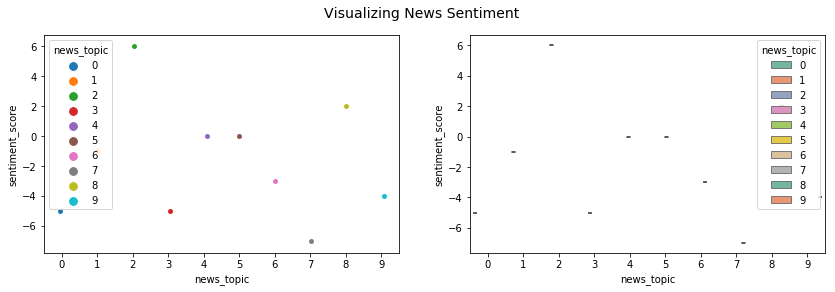

In [48]:
!pip install seaborn==0.9.0
import seaborn as sns
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
sp = sns.stripplot(x='news_topic', y="sentiment_score", 
                   hue='news_topic', data=df, ax=ax1)
bp = sns.boxplot(x='news_topic', y="sentiment_score", 
                 hue='news_topic', data=df, palette="Set2", ax=ax2)
t = f.suptitle('Visualizing News Sentiment', fontsize=14)

The topics which are seen above 0 on y axis have positive sentiment, 0 means neutral where as below 0 means negative polarity of topic.

To verfiy, we cross check with topics from LDA. 

e.g. 
Topic 3 - has a score of -5 and it contains words like - "kill" with higest weightage. As *kill*  is definitely a string negative word, which justifies the sentiment polarity.

##Sentiment analysis using TextBlob

This sentiment analyzer outputs mean values belonging to 3 categories - positive, negative and neutral.

In [49]:
from textblob import TextBlob

# compute sentiment scores (polarity) and labels
sentiment_scores_tb = [round(TextBlob(topic).sentiment.polarity, 3) for topic in topics_list]
sentiment_category_tb = ['positive' if score > 0 
                             else 'negative' if score < 0 
                                 else 'neutral' 
                                     for score in sentiment_scores_tb]


# sentiment statistics per news category
topics = list(range(NUM_TOPICS))
df = pd.DataFrame([topics, sentiment_scores_tb, sentiment_category_tb]).T
df.columns = ['news_topic', 'sentiment_score', 'sentiment_category']
df['sentiment_score'] = df.sentiment_score.astype('float')
df.groupby(by=['news_topic']).describe()

sentiment_score                                              
                     count   mean std    min    25%    50%    75%    max
news_topic                                                              
0                      1.0  0.000 NaN  0.000  0.000  0.000  0.000  0.000
1                      1.0 -0.100 NaN -0.100 -0.100 -0.100 -0.100 -0.100
2                      1.0  0.418 NaN  0.418  0.418  0.418  0.418  0.418
3                      1.0  0.000 NaN  0.000  0.000  0.000  0.000  0.000
4                      1.0  0.000 NaN  0.000  0.000  0.000  0.000  0.000
5                      1.0 -0.133 NaN -0.133 -0.133 -0.133 -0.133 -0.133
6                      1.0  0.000 NaN  0.000  0.000  0.000  0.000  0.000
7                      1.0 -0.075 NaN -0.075 -0.075 -0.075 -0.075 -0.075
8                      1.0  0.143 NaN  0.143  0.143  0.143  0.143  0.143
9                      1.0 -0.100 NaN -0.100 -0.100 -0.100 -0.100 -0.100

Based on the different lexicons, the sentiment polarity can change.  As per our models and topics that we modelled, we feel that using AFINN as our sentiment analyzer gives results closer to the actual sentiment of the topics.